In [3]:
#load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn import metrics

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import mean_squared_error
from sklearn import model_selection
from sklearn import preprocessing
from sklearn.model_selection import TimeSeriesSplit
from sklearn.feature_selection import SelectFromModel

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

# import xgboost as xgb
import itertools

from matplotlib import pyplot as mp
# import seaborn as sns
# import os
# import warnings
# warnings.filterwarnings('ignore')

## Loading in Data and Cleaning


In [5]:
permno=pd.read_excel('PERMNO_Tickers.xlsx')
rets = pd.read_excel('Returns_Clean.xlsx')
flows = pd.read_excel('Flows_Clean.xlsx')


In [6]:
#Constructing Data set 

data = pd.DataFrame( columns = ['Dates', 'PERMNO', 'Ret_i', 'Ret_lag1', 'Ret_lag2', 'Ret_lag3', 'Flow_lag1', 'Flow_lag2', 'Flow_lag3'])

 #Dates
#data['Dates'] = permno['Dates'].shift(-3)
#data.fillna(0)



    

In [6]:
#Functions for lags for returns and flows - keep in mind will have to generate columns for temporary and original data frames and name them e.g df['Return_' + str(lag)], 
#and then populate them like we do in the for loop below.

In [7]:
maxlag = 3 # 3 lags
i = maxlag
for perm in rets.columns[rets.columns != 'Dates']:
        
        
       
        
        temp = pd.DataFrame(columns = ['Dates', 'PERMNO', 'Ret_i', 'Ret_lag1', 'Ret_lag2', 'Ret_lag3', 'Flow_lag1', 'Flow_lag2', 'Flow_lag3'])
        
        
       
        #Dates and Permno's
        
        print(perm)

     
        
        temp['Dates'] = rets['Dates']
        temp['PERMNO'] = perm
        
        #Return and lagged returns - we can honestly change this into calling a function for number of lags
        temp["Ret_i"]= rets[perm]
        temp["Ret_lag1"]= temp["Ret_i"].shift(1)
        temp["Ret_lag2"]= temp["Ret_i"].shift(2)
        temp["Ret_lag3"]= temp["Ret_i"].shift(maxlag)
        temp.dropna(subset = ['Ret_i', 'Ret_lag1', 'Ret_lag2', 'Ret_lag3'], inplace = True)
        
        
        #Flows - we can honestly change this into calling a function for number of lags
        temp['Flow_lag1'] = flows[perm].shift(1)
        temp['Flow_lag2'] = flows[perm].shift(2)
        temp['Flow_lag3'] = flows[perm].shift(maxlag)
        
   
   
        temp.dropna(inplace = True)
        
        data = pd.concat([data, temp], ignore_index = True)
        
        
    

    

        
    
    

55976
41072
27748
75259
40970
62519
21792
54084
55511
10302
76091
27887
75228
25232
67459
32299
39571
23975
56143
41355
62308
25304
75174
20618
60580
90916
70018
15069
23552
59184
38973
58800
64020
48282
25443
77643
20415
25961
76081
66245
23229
31077
67563
76638
68340
39490
52396
19393
24184
64936
42024
63765
55781
56232
22509
10147
24109
63554
23990
58675
11674
75072
34497
21928
27684
66181
49373
62228
27043
75241
58421
53613
11819
48960
22103
21960
77461
63976
76605
11509
23077
29209
33937
64995
52708
10145
75100
67678
41080
64194
63829
44986
11891
22752
27780
59379
75162
27705
54594
48725


In [8]:
data

,Dates,PERMNO,Ret_i,Ret_lag1,Ret_lag2,Ret_lag3,Flow_lag1,Flow_lag2,Flow_lag3
0,19930406,55976,-0.067227,-0.024590,-0.020080,-0.019685,-5.642141,-6.975709,-4.696503
1,19930407,55976,0.000000,-0.067227,-0.024590,-0.020080,-6.975709,-5.642141,-6.975709
2,19930408,55976,0.040541,0.000000,-0.067227,-0.024590,-6.975709,-6.975709,-5.642141
3,19930412,55976,0.038961,0.040541,0.000000,-0.067227,-6.975709,-6.975709,-6.975709
4,19930413,55976,-0.033333,0.038961,0.040541,0.000000,-3.351631,-6.975709,-6.975709
...,...,...,...,...,...,...,...,...,...
195495,20001222,48725,0.026415,0.037859,-0.030380,0.066127,5.569106,-3.791130,7.960677
195496,20001226,48725,0.003676,0.026415,0.037859,-0.030380,5.934239,5.569106,-3.791130
195497,20001227,48725,0.028083,0.003676,0.026415,0.037859,-1.281796,5.934239,5.569106
195498,20001228,48725,-0.040380,0.028083,0.003676,0.026415,3.428868,-1.281796,5.934239


In [29]:
#In Sample expanding window test
def rollingWindowTrain(w, model, XTrain, YTrain):
    
    #Historical Mean model
    histmean = YTrain.pivot_table(index='Dates',columns='PERMNO',values='Ret_i').rolling(w).mean()
   # print((histmean.index))

    #YTrain = YTrain.pivot_table(index=YTrain.index,columns='PERMNO',values='Ret_i')
    
    date_Start = XTrain["Dates"].iloc[0]
    rmse_mod_l = []
    rmse_hist_l = []
    dates_plot = []
    
    
    
    for i in range(w, (len(histmean.iloc[:,0]))-1): #one increment, you can change by incrementing by 0.2*w and adjusting the indexing from there, so just let i jump by 0.2*w instead of just ones then it all should work
        
        w_date = histmean.index[i]
      
   
        x_w = XTrain[XTrain["Dates"]<=w_date]
        
       #taking away unnecesary columns
        x_w = XTrain[XTrain["Dates"]>=histmean.index[i-w]]
        # print(x_w)
        x_w = x_w.drop("PERMNO", axis = 1)
        x_w = x_w.drop("Dates", axis = 1)
        
        y_w = YTrain[YTrain["Dates"]<=w_date]
        y_w = YTrain[YTrain["Dates"]>=histmean.index[i-w]]
        y_w = y_w.drop("PERMNO", axis = 1)
        y_w = y_w.drop("Dates", axis = 1)
     
        print(x_w)
        print(y_w)

    #fitting model
        #print("For window - ", i, " - ", i+w)
        model.fit(x_w, y_w) #Model
        #print(model.coef_)
        
        
    #NEXT HERE TESTING WITH T+1 -
        #prediction x
        x_p = XTrain[XTrain["Dates"]==histmean.index[i+1]]
        x_p = x_p.drop("PERMNO", axis = 1)
        x_p = x_p.drop("Dates", axis = 1)
        
        # print(x_p)
        y_pred = model.predict(x_p)
        # print(y_pred[:10])
        print('------')
    
        #True 
        y_t =YTrain[YTrain["Dates"]==histmean.index[i-w]]
        y_t = y_t.drop("PERMNO", axis = 1)
        y_t = y_t.drop("Dates", axis = 1)
        
        
        #RMSE 
        rmse_mod = mean_squared_error(y_t, y_pred)
        
        
        rmse_histmean = mean_squared_error(y_t, histmean.iloc[i,:])
        #print("RMSE_mod = ", rmse_mod)
        #print("RMSE_hist = ", rmse_histmean)
        
        #lists for graph plotting 
        
        
    #compare to Historical mean model which you have as part of the rolling histmean just access it
        
        rmse_mod_l.append(rmse_mod)
        rmse_hist_l.append(rmse_histmean)
        dates_plot.append(rets["Dates"].iloc[i])
        
        
    return  rmse_mod_l, rmse_hist_l, dates_plot          
                       
                       
        
        
    
    

In [24]:
#train test split - 80:20 - #19990616 is 80% cutoff date (time series split)
df_train = data

df_test = data
#train x, y
y_train = df_train.filter(['Dates', 'PERMNO', 'Ret_i'])
x_train = df_train.drop("Ret_i", axis = 1)
print(y_train)
print(x_train)

#test x,y

y_test = df_test.filter(['Dates', 'PERMNO', 'Ret_i'])
x_test = df_test.drop("Ret_i", axis = 1)


           Dates PERMNO     Ret_i
0       19930406  55976 -0.067227
1       19930407  55976  0.000000
2       19930408  55976  0.040541
3       19930412  55976  0.038961
4       19930413  55976 -0.033333
...          ...    ...       ...
195495  20001222  48725  0.026415
195496  20001226  48725  0.003676
195497  20001227  48725  0.028083
195498  20001228  48725 -0.040380
195499  20001229  48725  0.004950

[195500 rows x 3 columns]
           Dates PERMNO  Ret_lag1  Ret_lag2  Ret_lag3  Flow_lag1  Flow_lag2  \
0       19930406  55976 -0.024590 -0.020080 -0.019685  -5.642141  -6.975709   
1       19930407  55976 -0.067227 -0.024590 -0.020080  -6.975709  -5.642141   
2       19930408  55976  0.000000 -0.067227 -0.024590  -6.975709  -6.975709   
3       19930412  55976  0.040541  0.000000 -0.067227  -6.975709  -6.975709   
4       19930413  55976  0.038961  0.040541  0.000000  -3.351631  -6.975709   
...          ...    ...       ...       ...       ...        ...        ...   
195495  2000

In [30]:

rms_model, rms_mean, dates = rollingWindowTrain(1950, LinearRegression(), x_train, y_train)

           Dates PERMNO  Ret_lag1  Ret_lag2  Ret_lag3  Flow_lag1  Flow_lag2  \
0       19930406  55976 -0.024590 -0.020080 -0.019685  -5.642141  -6.975709   
1       19930407  55976 -0.067227 -0.024590 -0.020080  -6.975709  -5.642141   
2       19930408  55976  0.000000 -0.067227 -0.024590  -6.975709  -6.975709   
3       19930412  55976  0.040541  0.000000 -0.067227  -6.975709  -6.975709   
4       19930413  55976  0.038961  0.040541  0.000000  -3.351631  -6.975709   
...          ...    ...       ...       ...       ...        ...        ...   
195495  20001222  48725  0.037859 -0.030380  0.066127   5.569106  -3.791130   
195496  20001226  48725  0.026415  0.037859 -0.030380   5.934239   5.569106   
195497  20001227  48725  0.003676  0.026415  0.037859  -1.281796   5.934239   
195498  20001228  48725  0.028083  0.003676  0.026415   3.428868  -1.281796   
195499  20001229  48725 -0.040380  0.028083  0.003676 -11.641011   3.428868   

        Flow_lag3  
0       -4.696503  
1       -6.

In [146]:
rms_model

[0.0005232477583989977,
 0.0003418852551800669,
 0.0004904901575387664,
 0.0010301469160884271]

In [147]:
rms_mean

[0.0004922314308342577,
 0.0003568710304514967,
 0.00046970823397358123,
 0.0009492742750223536]

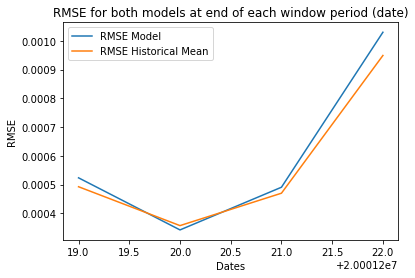

In [153]:
## Plotting RMSE

plt.plot(dates,rms_model, label="RMSE Model")
plt.plot( dates,rms_mean, label="RMSE Historical Mean")
plt.legend()
plt.title("RMSE for both models at end of each window period (date)")
plt.xlabel("Dates")
plt.ylabel("RMSE")
plt.show()


In [91]:
rets.row_index.values

AttributeError: 'DataFrame' object has no attribute 'row_index'

In [554]:
y_train

,PERMNO,Ret_i
Dates,,
19930406,55976,-0.067227
19930407,55976,0.000000
19930408,55976,0.040541
19930412,55976,0.038961
19930413,55976,-0.033333
19930414,55976,-0.060345
19930415,55976,0.013761
19930416,55976,-0.036199
19930419,55976,0.004695


In [107]:
rets

,Dates,55976,41072,27748,75259,40970,62519,21792,54084,55511,...,63829,44986,11891,22752,27780,59379,75162,27705,54594,48725
0,19930401,-0.019685,0.019391,-0.007282,-0.003891,0.083333,0.027027,0.005348,0.020000,-0.010417,...,0.108108,-0.019048,-0.017857,-0.028269,0.000000,0.006173,-0.023669,0.000000,0.031915,0.014433
1,19930402,-0.020080,0.002717,-0.002445,0.058594,-0.038462,-0.026316,-0.007979,-0.019608,-0.021053,...,0.000000,-0.016181,-0.031818,-0.010909,0.000000,-0.020450,0.012121,-0.032609,0.020619,-0.010163
2,19930405,-0.024590,-0.006775,-0.002451,0.022140,-0.040000,0.027027,0.005362,0.000000,0.021505,...,-0.048780,-0.003289,0.032864,0.003676,-0.005102,0.018789,-0.005988,-0.011236,-0.010101,0.026694
3,19930406,-0.067227,0.009550,-0.007371,0.025271,0.041667,0.052632,0.005333,0.000000,0.000000,...,-0.025641,-0.023102,-0.009091,-0.007326,0.005128,0.002049,-0.024096,-0.011364,-0.010204,0.014000
4,19930407,0.000000,0.005405,0.000000,0.021127,0.040000,-0.050000,0.002653,0.000000,0.010526,...,-0.013158,0.016892,0.018349,0.000000,0.010204,0.014315,0.000000,0.011494,0.000000,0.005917
5,19930408,0.040541,-0.005376,0.000000,0.010345,-0.038462,0.052632,0.000000,-0.020000,0.000000,...,-0.040000,0.003322,0.009009,-0.022140,0.025253,0.034274,0.030864,-0.011364,0.000000,0.001961
6,19930412,0.038961,0.017568,0.004950,0.000000,-0.080000,0.000000,0.010582,0.000000,-0.010417,...,0.055556,-0.013245,0.040179,0.033962,-0.004926,0.033138,-0.005988,-0.011494,0.020619,0.019569
7,19930413,-0.033333,-0.006640,0.002463,-0.006826,-0.086957,0.000000,0.005236,0.000000,0.042105,...,0.000000,0.000000,0.034335,-0.010949,-0.004950,0.009434,0.000000,0.000000,0.020202,0.007678
8,19930414,-0.060345,0.014706,0.000000,-0.003436,0.047619,0.000000,-0.002604,0.000000,-0.010101,...,-0.026316,0.013423,0.012448,-0.003690,0.019900,-0.042991,-0.018072,-0.034884,0.009901,-0.007619
9,19930415,0.013761,0.011858,-0.007371,-0.034483,0.045455,0.000000,0.005222,0.000000,0.040816,...,0.081081,0.006623,-0.004098,-0.018519,0.014634,-0.025391,-0.006135,0.012048,0.009804,-0.013436


In [109]:
data

,Dates,PERMNO,TICKER,Ret_i,Ret_lag1,Ret_lag2,Ret_lag3,Flow_lag1,Flow_lag2,Flow_lag3
0,NaN,10145,ALD,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,10145,ALD,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,10145,ALD,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,10145,ALD,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,10145,ALD,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,10145,ALD,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,10145,ALD,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,10145,ALD,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,10145,ALD,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,10145,ALD,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [343]:
flows

,Dates,55976,41072,27748,75259,40970,62519,21792,54084,55511,...,63829,44986,11891,22752,27780,59379,75162,27705,54594,48725
0,19930401,-4.696503,-23.581608,0.904076,1.960112,0.687935,-1.791999,-1.465184,-0.124006,-1.681277,...,-3.762768,-1.733699,1.126364,-7.138398,3.073116,1.617669,2.448601,3.493056,0.902557,-0.535050
1,19930402,-6.975709,-23.331232,0.394204,23.691814,-1.895012,0.551048,-1.488078,-0.170873,-1.588607,...,-0.419981,-2.612104,0.019097,-7.138398,2.033127,-2.418096,-1.523983,-9.594576,-10.226385,-0.274176
2,19930405,-5.642141,-19.851716,-1.597132,8.839406,0.475161,8.010732,0.298018,0.281993,1.024464,...,-0.474352,1.625321,1.149879,-6.056788,2.309195,4.493038,0.854999,2.615968,0.817579,1.478560
3,19930406,-6.975709,23.276153,-1.129123,14.299749,1.426277,9.120669,-0.317257,-0.059609,5.883830,...,-1.294707,1.255646,0.803975,-2.927825,-5.331582,1.635919,-9.876419,-2.862576,-3.755393,1.674835
4,19930407,-6.975709,19.204137,-1.221991,-5.184144,-1.638974,0.808131,-0.463507,0.610452,-1.209499,...,0.000000,8.642735,1.060310,-2.069588,-1.625845,2.295149,0.570760,5.847429,-1.580178,1.814051
5,19930408,-6.975709,0.560749,-1.436277,6.040777,-1.034320,19.670714,-5.074804,0.688991,-6.059106,...,0.412177,5.586273,2.967882,-5.260498,0.484742,12.213694,0.297741,-4.991003,-1.221645,0.205041
6,19930412,-3.351631,-1.993177,-3.149916,2.100766,-0.456173,29.969740,1.944966,0.508484,-0.919980,...,1.638128,-4.777620,4.521376,-3.373292,-0.780234,1.779914,1.533468,-2.804367,-4.795620,0.819203
7,19930413,-2.878666,-3.238632,0.060249,0.323572,2.446547,15.992772,0.274019,1.166131,1.302009,...,0.454086,-40.314867,7.367280,-4.528327,1.660976,-11.525256,-1.492312,-2.508979,1.846624,1.384477
8,19930414,-6.975709,21.718050,-1.271246,3.030526,-0.345445,-11.870531,-2.583908,-0.771997,3.690216,...,0.125484,-1.895170,3.875177,-2.722528,-0.750881,-18.556932,-1.696118,3.777336,6.946835,4.387446
9,19930415,-6.975709,24.959539,1.099761,-16.581264,-0.331055,11.662401,1.073347,-0.624873,2.767425,...,0.120633,-0.764309,1.929401,-5.451858,-2.098065,-14.936359,0.537455,-0.818048,3.727801,-0.159646
